In [3]:
import pandas as pd
pd.options.display.max_columns = None

In [4]:
df = pd.read_csv('data_celulares_modelo.csv').iloc[:,1:]

#### DEFINICION  DE FUNCIONES
CLASIFICADOR NAIVE BAYES 

In [5]:
def naive_bayes(p_df, predecir=[], v_target=3):
    #DEPENDENCIAS
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,accuracy_score 
    from sklearn.naive_bayes import MultinomialNB
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns
    scaler = StandardScaler()
    from sklearn.feature_extraction.text import TfidfVectorizer
    import unidecode as ud
    
    df = p_df
    
    if v_target==3:
        df_aux = df[df.ventas==0].sample(190)
        df = df[df.ventas!=0]
        df =  pd.concat([df,df_aux],axis=0)
        df.ventas = df.ventas.apply(lambda x: 0 if (x<=1) else 1 if ((x>1)&(x<=5)) else 2)
        df.ventas.value_counts()
    else:
        df.ventas = pd.qcut(df.ventas,2,labels=[0,1])
        
    X = pd.DataFrame({'titulo':df.titulo})
    X = X.titulo.apply(lambda x : ud.unidecode(x).lower())
    y = df.ventas

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)
    modelo_tfidf = TfidfVectorizer(ngram_range=(2,3), max_df=0.65)
    X_train = modelo_tfidf.fit_transform(X_train)
    y_train = np.array(y_train)
    if v_target==3:
        modelo_NB = MultinomialNB(alpha=0.001,class_prior=[.75,.99,.80])
    else:
        modelo_NB = MultinomialNB(alpha=0.001,class_prior=[.60,.30])
    modelo_NB.fit(X_train, y_train)
    X_test = modelo_tfidf.transform(X_test)
    X_test.get_shape()
    predicciones = modelo_NB.predict(X_test)
    predicciones_proba = modelo_NB.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predicciones)
    #print('ROC_AUC_SCORE: ',roc_auc_score(y_test, predicciones))
    print(' ')
    print(classification_report(y_test,predicciones))
    print('')
    print(confusion_matrix(y_test,predicciones))
    mat = confusion_matrix(y_test, predicciones)
    sns.heatmap(mat, square=True, annot=True, fmt='d')
    plt.xlabel('Etiquetas predichas')
    plt.ylabel('Etiquetas verdaderas')
    salida = []
    if pd.Series(predecir).shape[0] != 0:
        for i in predecir:
            nuevos_X = pd.Series(i)
            nuevos_X = modelo_tfidf.transform(nuevos_X)
            if v_target==3:
                dic = {0:'pocas',1:'medias',2:'altas'}
            else:
                dic = {0:'pocas',1:'muchas'}
            pd.DataFrame(modelo_NB.predict_proba(nuevos_X))

            if (modelo_NB.predict_proba(nuevos_X).max())>0.45:
                print('')
                print('Prediccion de ventas para '+i+': ',dic[modelo_NB.predict(nuevos_X)[0]])
                print(modelo_NB.predict_proba(nuevos_X))
                if v_target==3:
                    salida_valor = modelo_NB.predict(nuevos_X)[0]
                    bar_df = pd.DataFrame(modelo_NB.predict_proba(nuevos_X),columns=['bajas ventas','medias ventas','altas ventas'])
                else:
                    salida_valor = modelo_NB.predict(nuevos_X)[0]
                    bar_df = pd.DataFrame(modelo_NB.predict_proba(nuevos_X),columns=['bajas ventas','altas ventas'])
                    
                salida.append((i,bar_df))
            else:
                salida_valor = -1
                print('')
                print('No se puede estimar correctamente')
    else:
        salida_valor = -2
        salida='n/p'
    return {'modeloPalabras':modelo_tfidf,'modelo':modelo_NB,'salida':salida,'salida_valor':salida_valor}


## CLASIFICADOR DE NAIVE BAYES UTILIZANDO 3 DIMENSIONES (POCAS(0), MEDIAS(1) Y MUCHAS(2))

In [6]:
df = pd.read_csv('data_celulares_modelo.csv').iloc[:,1:]
naive_bayes(df,v_target=3)

 
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       259
           1       0.72      0.73      0.73       258
           2       0.76      0.85      0.80       225

    accuracy                           0.76       742
   macro avg       0.77      0.77      0.77       742
weighted avg       0.77      0.76      0.76       742


[[187  45  27]
 [ 37 189  32]
 [  7  27 191]]


{'modeloPalabras': TfidfVectorizer(max_df=0.65, ngram_range=(2, 3)),
 'modelo': MultinomialNB(alpha=0.001, class_prior=[0.75, 0.99, 0.8]),
 'salida': 'n/p',
 'salida_valor': -2}

#### NAIVE BAYES PREDECIR VENTAS PARA = SAMSUNG GALAXY A30

In [11]:
l_celulares=['iPhone XR','Samsung Galaxy A30']

 
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       259
           1       0.74      0.72      0.73       258
           2       0.76      0.84      0.80       225

    accuracy                           0.77       742
   macro avg       0.77      0.77      0.77       742
weighted avg       0.77      0.77      0.77       742


[[196  36  27]
 [ 40 186  32]
 [  7  28 190]]

Prediccion de ventas para iPhone XR:  medias
[[0.22113872 0.76690411 0.01195716]]

Prediccion de ventas para Samsung Galaxy A30:  altas
[[0.19529359 0.21555886 0.58914756]]


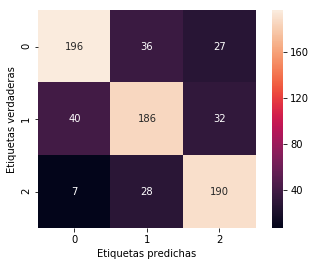

In [15]:
df = pd.read_csv('data_celulares_modelo.csv').iloc[:,1:]
df_bar = naive_bayes(df,l_celulares,v_target=3)['salida']

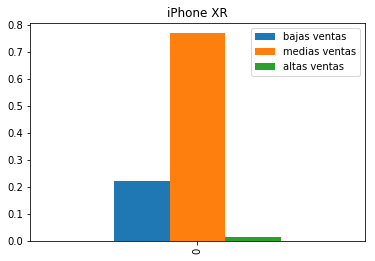

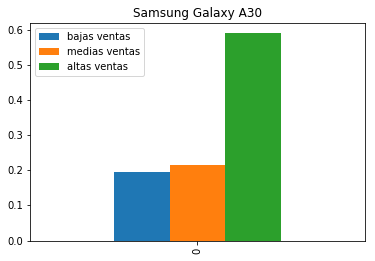

In [17]:
import matplotlib.pyplot as plt
for i in df_bar:
    i[1].plot.bar()
    plt.title(i[0])